## 1. Introduction

The restaurant dataset consists of a total of 17 attributes having thousands of different restaurants in different locations in the city of Bangalore. This kind of dataset can help online restaurant locators such as Zomato to promote targeted marketing. For example, if an Italian person is using Zomato, Zomato can provide the user with suggestions of different restaurants that provide Italian cuisine. Currently, Zomato recommends its users with the highest rated restaurants present in a particular locality based on user location. 

The intention of this assignment is to improve the application by estimating prices of restaurants based on certain attributes. In this dataset, there are a few attributes that are informative. Depending on how one views the data, we have identified the following attributes that provide a good insight to perform data analysis. The attributes are rate, location, restaurant type, approx cost for two people, cuisines, dish liked and listed in (type). 

With the above attributes, the following data analysis can be performed:
* Provide locations that offer certain types of dishes based on dishes liked by people cuisines offered etc.
* Provide information on a restaurant based on the brand name (a restaurant brand may offer food items in all their resturant chains)
* Perform sentiment analysis of the reviews list to check whether the restaurant treats its customers well

## Author

### Sudarshan Suresh Srikant  - sudarshan.suresh@dal.ca

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing as sk
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import re
from datetime import datetime
import sys
from skrebate import ReliefF

!pip install skrebate # Library for relief
# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Function to clean the rate attribute
def clean_rate(dataframe):
    dataframe = re.sub('/5', '',str(dataframe)) #Remove the string '/5' in all ratings
    dataframe = re.sub('-', 'nan', str(dataframe)) #Replacing all values containing '-' with NaN rating
    dataframe = re.sub('NEW', 'nan', str(dataframe)) #Replacing all values containing 'NEW' with NaN rating since the number of votes are also 0 and the restaurant is new
    return float(dataframe)

In [3]:
# Function to clean the approx cost(for two people) attribute
def clean_approx_cost(dataframe):
    dataframe = re.sub(',','', str(dataframe))
    return float(dataframe)

In [4]:
# Function to standardize data
# The numeric columns such as rate and votes have been standardized to follow a Gaussian distribution with a zero mean and unit variance. 
# The reason behind this is because the variable weights must be balanced and must not outweigh each other.
def scale_to_zero_mean_and_unit_variance(column):
    scaled_data = np.array(sk.scale(column))
    scaled_data = np.reshape(scaled_data,(scaled_data.shape[0],1))
    return scaled_data

In [5]:
def one_hot_encoding_of_column(column):
    # First, use LabelEncoder to convert Strings to numeric values as OHE does not accept Strings
    lab_enc = sk.LabelEncoder()
    lab_enc.fit(column)
    label_encoded = lab_enc.transform(column)
    
    # Reshape the label_encoded array into a Nx1 matrix as OHE requires a 2-D matrix as input
    label_encoded = np.reshape(label_encoded, (label_encoded.shape[0],1))
    
    # Perform One-Hot-Encoding
    OHE_encoder = sk.OneHotEncoder(sparse=False)
    OHE_encoder.fit(label_encoded)
    OHE_result = OHE_encoder.transform(label_encoded)

    return OHE_result

In [6]:
def multi_label_binarize_column(column):
    mlb = MultiLabelBinarizer()
    mlb_binarized = mlb.fit_transform(column)
    return mlb_binarized

In [7]:
def preprocess_data(data):

    # Scale the rate column
    clean_data = scale_to_zero_mean_and_unit_variance(data[:,0])
    
    # One-hot-encode the location column
    location_column_clean = one_hot_encoding_of_column(data[:,1])
    clean_data = np.append(clean_data, location_column_clean, axis=1)
    
    # Encode rest-type column using multi label binarizer
    rest_type_column_clean = multi_label_binarize_column(data[:,2])
    clean_data = np.append(clean_data, rest_type_column_clean, axis=1)
    
    # Encode cuisines column using multi label binarizer
    cuisines_column_clean = multi_label_binarize_column(data[:,3])
    clean_data = np.append(clean_data, cuisines_column_clean, axis=1)   
    
    return clean_data

In [8]:
def preprocess_relief_data(data):
    
    # One-hot-encode the online order column
    clean_data = multi_label_binarize_column(data[:,0])
    
    # One-hot-encode the book_table column
    book_table_column_clean = multi_label_binarize_column(data[:,1])
    clean_data = np.append(clean_data, book_table_column_clean, axis=1)
    
    # One-hot-encode the rate column
    rate_column_clean = scale_to_zero_mean_and_unit_variance(data[:,2])
    clean_data = np.append(clean_data, rate_column_clean, axis=1)
    
    # Standardize the votes column
    votes_column_clean = scale_to_zero_mean_and_unit_variance(data[:,3])
    clean_data = np.append(clean_data, votes_column_clean, axis=1)
    
    # One-hot-encode the location column
    location_column_clean = one_hot_encoding_of_column(data[:,4])
    clean_data = np.append(clean_data, location_column_clean, axis=1)
    
    # Multi label binarize the restaurant type column
    rest_type_column_clean = multi_label_binarize_column(data[:,5])
    clean_data = np.append(clean_data, rest_type_column_clean, axis=1)
    
    # Multi label binarize the cuisines column
    cuisines_column_clean = multi_label_binarize_column(data[:,6])
    clean_data = np.append(clean_data, cuisines_column_clean, axis=1)
    
    # One-hot-encode the listed_in(type) column
    listed_in_type_column_clean = one_hot_encoding_of_column(data[:,7])
    clean_data = np.append(clean_data, listed_in_type_column_clean, axis=1)
  
    
    return clean_data

In [9]:
def plot_numeric_attributes(group_by_col,numeric_col):
    grouped_locs = original_df.groupby(group_by_col)[numeric_col].mean()
    grouped_locs.plot(kind='bar', figsize=(30,10), legend=True).set_ylabel(numeric_col)

In [10]:
def plot_categorical_attributes(group_by_col,categorical_col):
    grouped_locs = original_df.groupby(group_by_col)[categorical_col].value_counts().unstack()
    grouped_locs.plot(kind='bar', figsize=(30,10), legend=True).set_ylabel(categorical_col)

## 2. a. Load the data

In [11]:
# Load the data
df = pd.read_csv('zomato.csv', encoding='utf-8')
# Use original_df for relief without dropping any column
original_df = df
original_df['votes'] = original_df['votes'].astype(float)
# Use df to consider only the four attributes listed in Question 3
df = df.drop(columns=['url','phone','reviews_list','menu_item','listed_in(city)'])
print(df.shape)
print(original_df.shape)

(51717, 12)
(51717, 17)


## 2. b. Plot the distribution of attributes and trends in data based on location

## Trends in votes

After grouping by location, the dataset has certain locations that have a high number of votes. The location 'Church Street' seems to have restaurants with the highest number of votes. This might suggest the users that Chruch Street may have good restaurants.

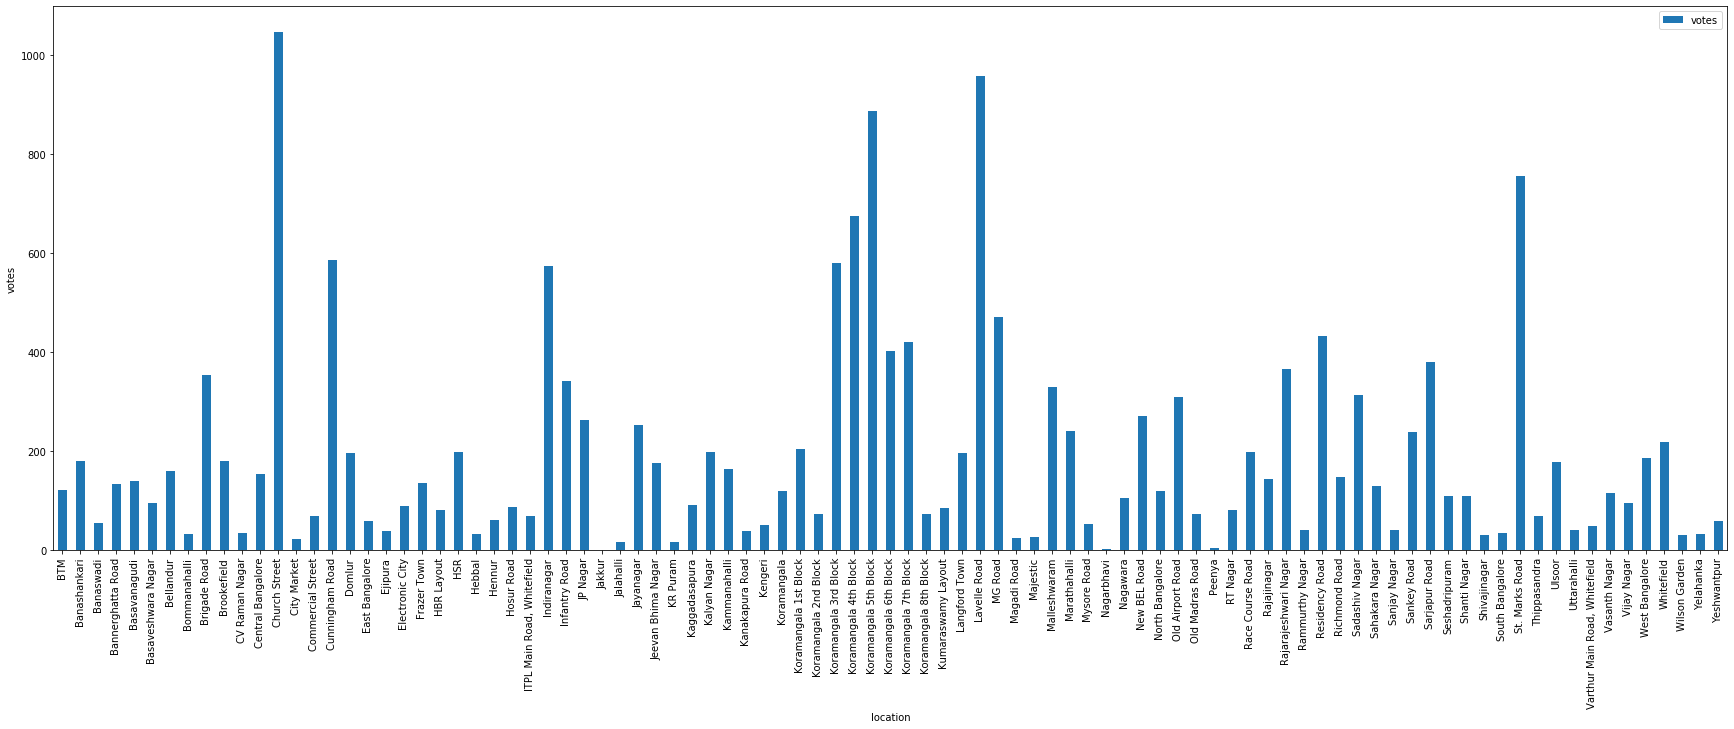

In [12]:
plot_numeric_attributes('location','votes')

## Trends in online orders

After grouping by location, the dataset has certain locations that have restaurants that accept online orders. The location 'Church Street' seems to have restaurants with the highest number of votes. This might suggest the users that Chruch Street may have good restaurants.

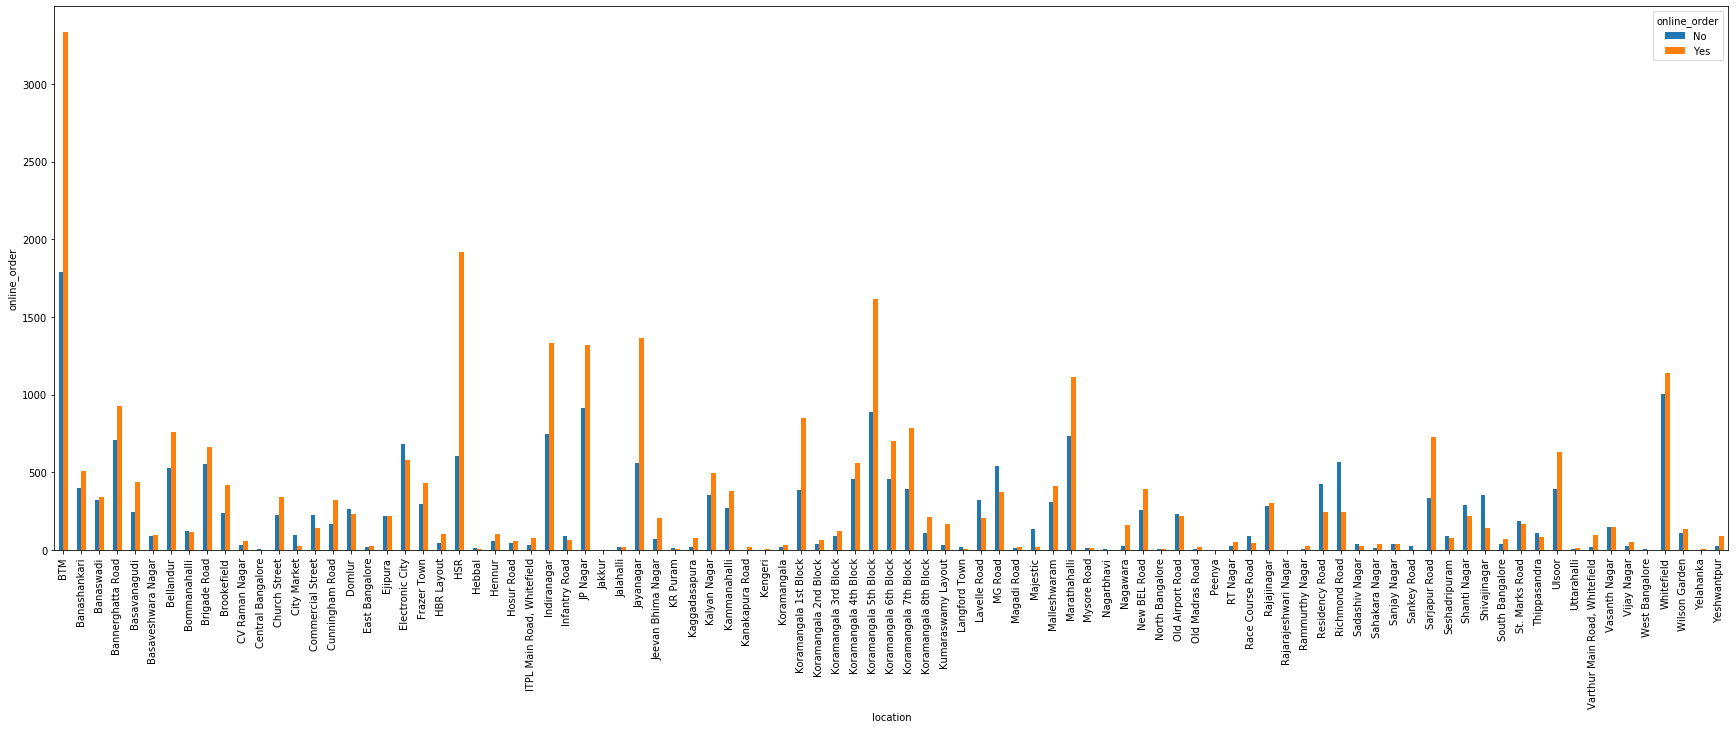

In [13]:
plot_categorical_attributes('location','online_order')

## Cleaning columns

The rate and approx cost for two people columns have NaN and invalid values. These values are cleaned. In the average rating column, the NaN values have been replaced with the mean rating instead of dropping them. This is done so that the distribution remains uniform. 

2.b. There are many attributes that are useless at this point such as url, name, address, phone, reviews_list, menu_item and listed_in(city). These attributes cannot be used to estimate the approx cost for two people. Even the attributes online_order and book_table can be removed because they may not be the best attributes to determine cost of a place. For example, there could be restaurants that would not have an online booking service nor can you order from such a place, but the place might provide food at high or low rates depending on other factors.

2.c. There were approximately 39000 duplicate restaurants in the dataset. And these values have been dropped by simply matching their names and addresses as shown below:

In [14]:
df['rate'] = df['rate'].apply(clean_rate)
df['rate'] = df['rate'].fillna(df['rate'].mean())
df.dropna(subset=['location','rest_type','cuisines','approx_cost(for two people)'], inplace=True)
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(clean_approx_cost)
df = df.drop_duplicates(subset=['name','address'], keep='first')
print(df.shape)

(12382, 12)


In [15]:
original_df['rate'] = original_df['rate'].apply(clean_rate)
original_df['rate'] = original_df['rate'].fillna(original_df['rate'].mean())
original_df.dropna(subset=['location', 'cuisines','rest_type','approx_cost(for two people)'], inplace=True)
original_df['approx_cost(for two people)'] = original_df['approx_cost(for two people)'].apply(clean_approx_cost)
original_df = original_df.drop_duplicates(subset=['name','address'], keep='first')
print(original_df.shape)

(12382, 17)


## Trends in approx cost for two people

The graph below shows locations that provide an approximate cost for two people. Based on the below grpah, we can see that the costliest restaurants are located in the 'Sankey Road' area. Apart from this location, other locations have food priced around the same range.

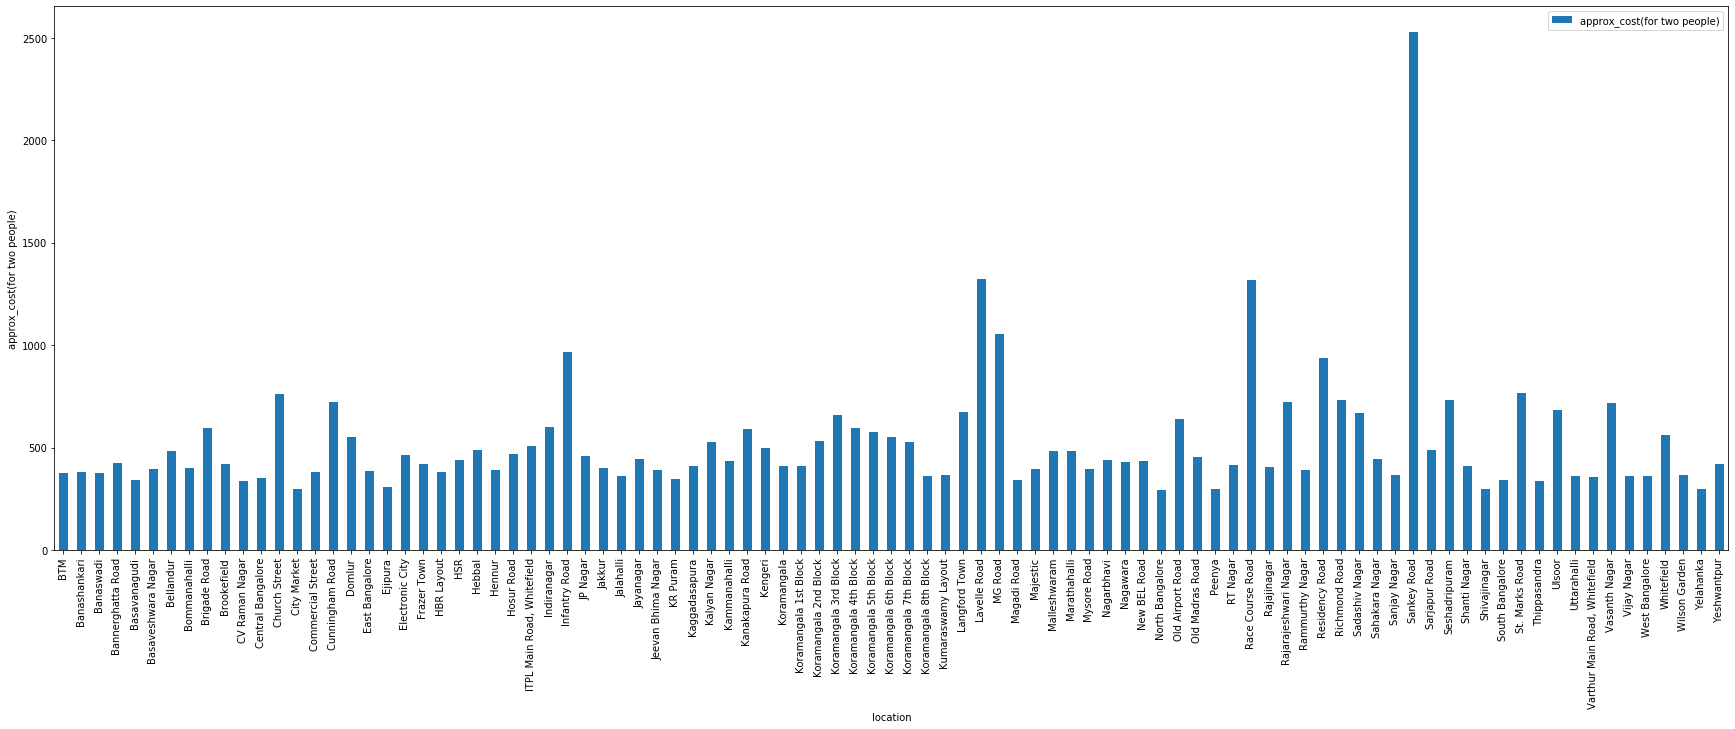

In [16]:
plot_numeric_attributes('location','approx_cost(for two people)')

## Trends in table booking

The graph below shows locations that facilitate booking a table in advance. As seen below, many resturants do not provide an option to book a table in advance.

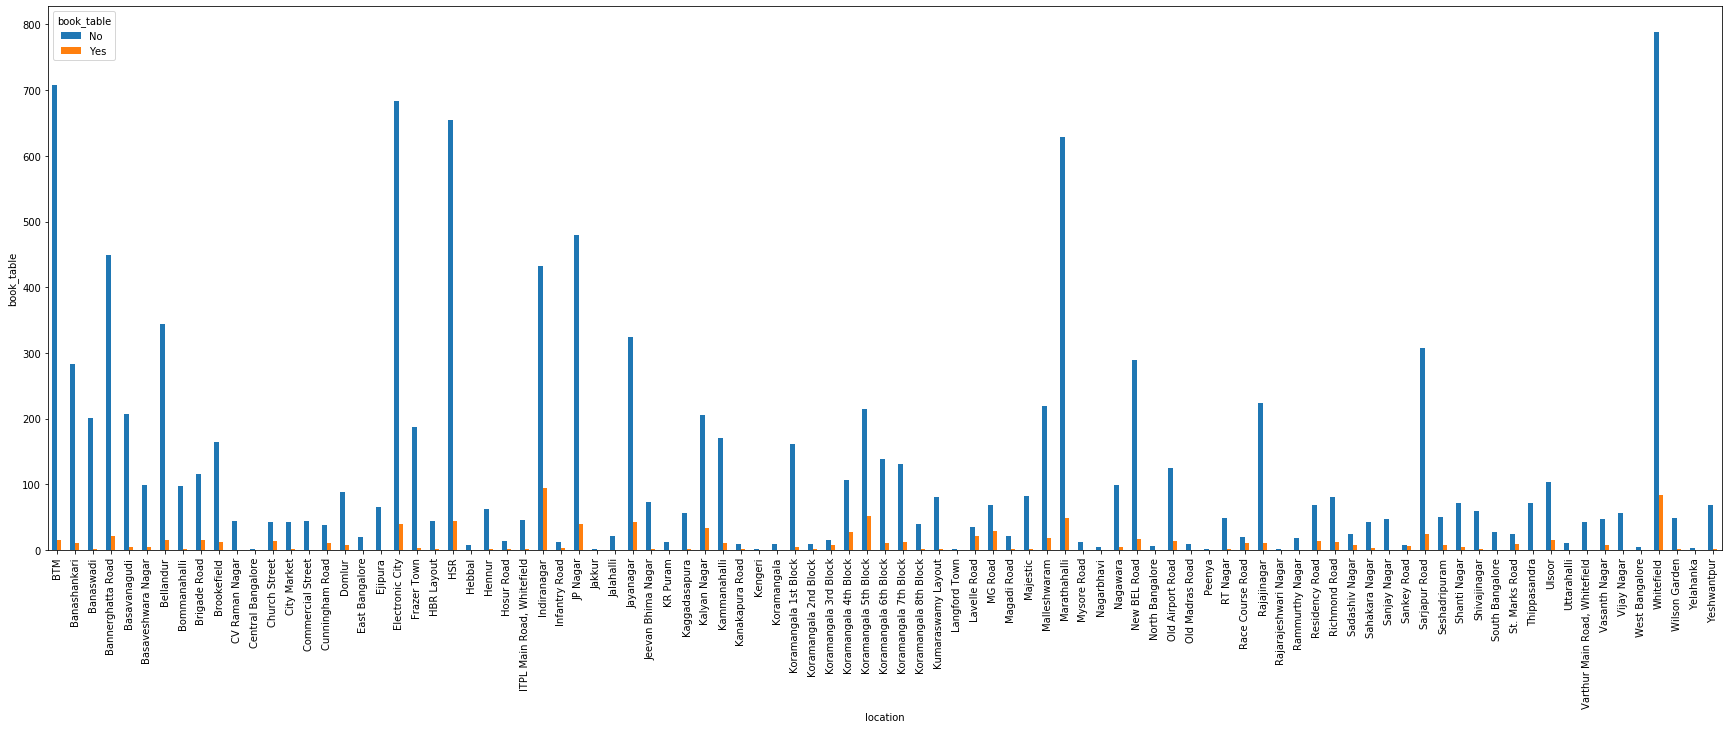

In [17]:
plot_categorical_attributes('location','book_table')

## Trends in rating

As seen below, most of the restaurants have an average rating of 3.5 out of 5. From this we can conclude that the people who visit restaurants in Bangalore have an above average experience.

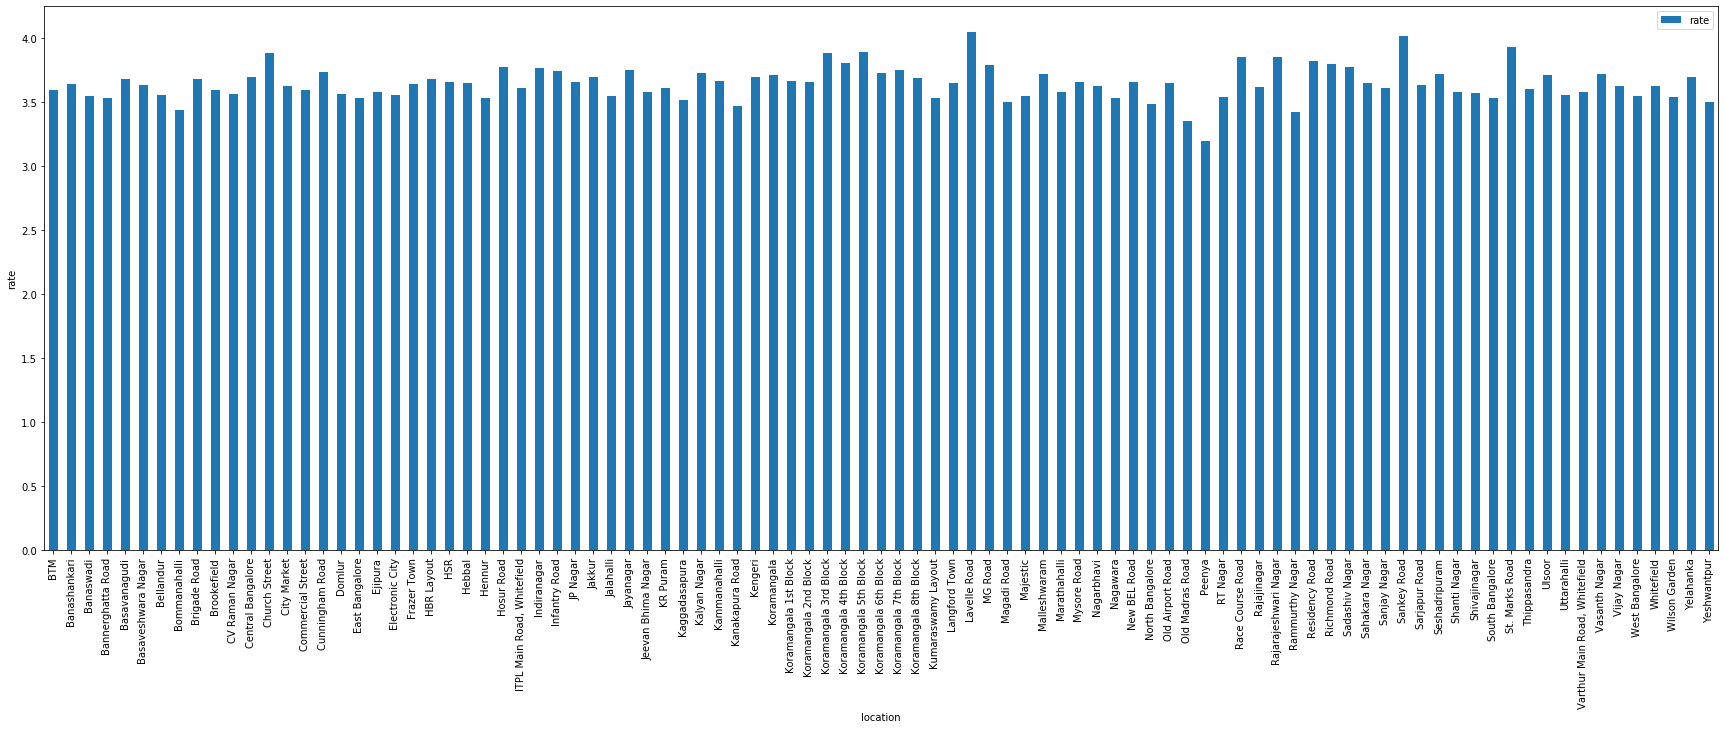

In [18]:
plot_numeric_attributes('location','rate')

## 2. d. Characteristics of the location with the highest average rated restrauants 

The code below lists the location with the highest average rated restaurants and lists the charactertics of the neighbourhood with the cuisines available in that particular area, restaurant types, average votes recieved in that area and the average approximate cost for two people in that location.

In [19]:
df_grouped_locations=df.groupby(['location'], as_index=False)['rate'].mean()
# Get the location with the maximum rating
print(f"Location with highest average rated restaurants: {df_grouped_locations.loc[df_grouped_locations['rate'] == max(df_grouped_locations['rate']), 'location'].iloc[0]}")
print(f"Max average rating for {df_grouped_locations.loc[df_grouped_locations['rate'] == max(df_grouped_locations['rate']), 'location'].iloc[0]}: {max(df_grouped_locations['rate'])}")

cuisine_array = np.unique(df[df['location']=="Lavelle Road"]['cuisines'])
cuisine_df = pd.DataFrame(data=cuisine_array, columns=['cuisines'])
print(f"\nCuisines available in the given neighbourhood: {set(cuisine_df['cuisines'].str.cat(sep=', ').split(' '))}")

rest_type_array = np.unique(df[df['location']=="Lavelle Road"]['rest_type'])
rest_type_df = pd.DataFrame(data=rest_type_array, columns=['rest_type'])
print(f"\nRestaurant type available in the given neighborhood: {set(rest_type_df['rest_type'].str.cat(sep=', ').split(' '))}")
      
print(f"\nAverage Approx cost for two people in the neighborhood: {df[df['location']=='Lavelle Road']['approx_cost(for two people)'].mean()}")
      
print(f"\nAverage votes for restaurants in the neighborhood: {df[df['location']=='Lavelle Road']['votes'].mean()}")
      

Location with highest average rated restaurants: Lavelle Road
Max average rating for Lavelle Road: 4.046460629853767

Cuisines available in the given neighbourhood: {'Finger', 'Momos', 'North', 'Burger,', 'Japanese,', 'Chinese,', 'Sandwich,', 'Bakery,', 'Indian,', 'Food,', 'BBQ,', 'Mexican,', 'American,', 'Street', 'Mediterranean,', 'Mughlai,', 'Salad,', 'Cream,', 'Rajasthani,', 'Healthy', 'Desserts,', 'Kebab,', 'Modern', 'Seafood,', 'Cafe,', 'Mangalorean,', 'Tex-Mex,', 'Asian,', 'Momos,', 'Parsi,', 'French,', 'Fast', 'European,', 'Indonesian,', 'Continental,', 'Steak,', 'Italian,', 'Thai,', 'Beverages,', 'Eastern,', 'Spanish,', 'Ice', 'Juices,', 'Pizza,', 'South'}

Restaurant type available in the given neighborhood: {'Kiosk,', 'Cafee,', 'Parlor,', 'Confectionery,', 'Beverage', 'Quick', 'Bakery,', 'Bites', 'Delivery,', 'Irani', 'Bites,', 'Shop,', 'Microbrewery,', 'Bar,', 'Casual', 'Cafe,', 'Dining,', 'Dessert', 'Pub,', 'Fine', 'Lounge,'}

Average Approx cost for two people in the neig

## 3. Building a machine learning model

3.a The problem is based on supervised learning and regression in particular because we are trying to predict the approx cost using the given attributes. Since the approx cost for two people is a continuous valued target attribute, the given task is a regression task.

3.b We have chosen four models: SVR, Random Forest, Gradient Boosting and MLP regressor models. But we decided to go with Random Forest regressor because it gave us the highest accuracy and also it would not overfit for a large input size. The final accuracy would be averaged out by the results of the individual trees. 

3.c We have used the R2 scoring metric to evaluate our model's performance. The R2 scoring metric provides us information as to how well the observed outcomes are replicated by the model, based on the ratio of total variation of outcomes explained by the model.

In [20]:
# Split dataset into inputs and target

df_labels = df.drop(columns=['name','online_order','book_table','dish_liked','votes','address','rate', 'location','rest_type','cuisines','listed_in(type)'])
df_data = df.drop(columns=['approx_cost(for two people)','online_order','address','votes','book_table','listed_in(type)','name', 'dish_liked'])
data_raw = df_data.as_matrix()
labels_raw = df_labels.as_matrix()

In [21]:
# Split dataset into inputs and target

original_df_labels = original_df.drop(columns=['url','votes','phone','dish_liked','address','reviews_list','menu_item','listed_in(city)','name','online_order','book_table','rate', 'location','rest_type','cuisines','listed_in(type)'])
original_df_data = original_df.drop(columns=['url','phone','approx_cost(for two people)','address','reviews_list','menu_item','dish_liked','name'])
original_data = original_df_data.as_matrix()
original_labels = original_df_labels.as_matrix()

In [22]:
# Encode the dataset
data = preprocess_data(data_raw)
original_data = preprocess_relief_data(original_data)

In [23]:
# Convert the target attribute from str to float 
labels_raw = labels_raw.astype(float)
original_labels = original_labels.astype(float)

In [24]:
svr_reg_cv = SVR()

svr_reg_cv_scores = cross_val_score(svr_reg_cv, data, labels_raw, cv=10, scoring='r2')
print(f"R2 score: {svr_reg_cv_scores.mean()}")

R2 score: 0.15390215793690812


In [25]:
mlp_reg_cv = MLPRegressor()
mlp_reg_cv_scores = cross_val_score(mlp_reg_cv, data, labels_raw, cv=10,scoring='r2')
print(f"R2 score: {mlp_reg_cv_scores.mean()}")

R2 score: 0.6896577854630752


In [26]:
rf_reg_cv = RandomForestRegressor()
rf_reg_cv_scores = cross_val_score(rf_reg_cv, data, labels_raw, cv=10,scoring='r2')
print(f"R2 score: {rf_reg_cv_scores.mean()}")

R2 score: 0.7263370487392127


In [27]:
gradientboost_reg_cv = GradientBoostingRegressor()
gradientboost_reg_cv_scores = cross_val_score(gradientboost_reg_cv, data, labels_raw, cv=8,scoring='r2')
print(f"R2 score: {gradientboost_reg_cv_scores.mean()}")

R2 score: 0.7188759779011491


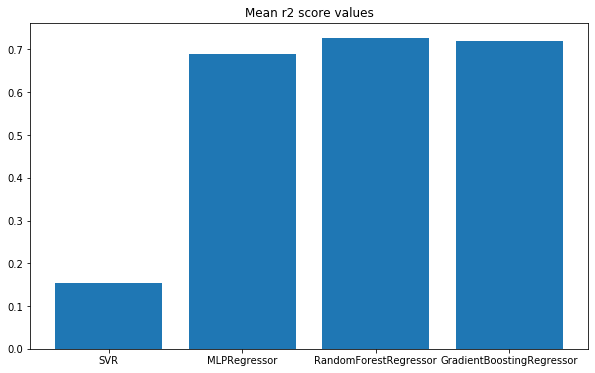

In [28]:
x_axis = ["SVR", "MLPRegressor", "RandomForestRegressor","GradientBoostingRegressor"]
model_accuracies = [svr_reg_cv_scores.mean(), mlp_reg_cv_scores.mean(), rf_reg_cv_scores.mean(), gradientboost_reg_cv_scores.mean()]
plt.figure(figsize=(10,6))
plt.bar(x_axis, model_accuracies)
plt.title("Mean r2 score values")
plt.show()

3.d. To make sure that we are not trying to overfit, we are performing an out of sample validation by splitting the dataset into train and test. We are doing this to check how well our model performs on train and validation data. We would expect our model to perform extremely well when it is built on train data and predicts on train data. This way we know that the model has learnt the dataset well. The performance is then measured against the validation data to make sure that our model does not give the exact same result as the train data prediction. This way we are preventing overfitting.

3.e. We are using cross validation to make sure that random subsets of the dataset are taken into consideration and a holdout validation is performed across these subsets. This way, the performance of the model is averaged across the subsets.

In [29]:
# Split the train data into train and validation 
X_train, X_validation, y_train, y_validation = train_test_split(data, labels_raw, test_size=0.10, random_state=42)
print(f"Dimensions of training data: {X_train.shape}")
print(f"Dimensions of validation data: {X_validation.shape}")

Dimensions of training data: (11143, 181)
Dimensions of validation data: (1239, 181)


In [30]:
rf_reg_train = RandomForestRegressor().fit(X_train,y_train)
rf_reg_train_pred = rf_reg_train.predict(X_train)
train_r2_score = r2_score(y_train,rf_reg_train_pred)
print(f"r2 score on train data: {train_r2_score}")

r2 score on train data: 0.9534924278333088


In [31]:
rf_reg_val = RandomForestRegressor().fit(X_train,y_train)
rf_reg_val_pred = rf_reg_val.predict(X_validation)
val_r2_score = r2_score(y_validation,rf_reg_val_pred)
print(f"r2 score on validation data: {val_r2_score}")

r2 score on validation data: 0.7662257356356252


In [32]:
rf_reg = RandomForestRegressor()
rf_train_scores = cross_val_score(rf_reg_cv, X_train, y_train, cv=10,scoring='r2')
print(f"Accuracy: {rf_train_scores}")

Accuracy: [0.76674753 0.77890199 0.76961741 0.77327859 0.75477547 0.70390246
 0.7852144  0.74593205 0.74734357 0.73491736]


In [33]:
rf_reg = RandomForestRegressor()
rf_val_scores = cross_val_score(rf_reg_cv, X_validation, y_validation, cv=10,scoring='r2')
print(f"Accuracy: {rf_val_scores}")

Accuracy: [0.79972613 0.65077049 0.72329006 0.69789807 0.59180924 0.66913249
 0.72197317 0.51880295 0.7351385  0.69107906]


### 3.f. Graphs to show the performance of train versus validation results.

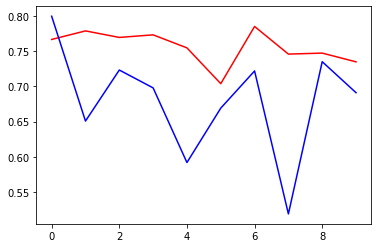

In [34]:
x_axis = ["R2 on train data", "R2 on validation data"]
plt.plot(rf_train_scores, 'r')
plt.plot(rf_val_scores, 'b')


3.c Comparing the values of cross validation and holdout validation. We can see that cross validation performs much better when compared to holdout validation because of the k-fold validation technique used in cross validation. Hence we are using cross validation.

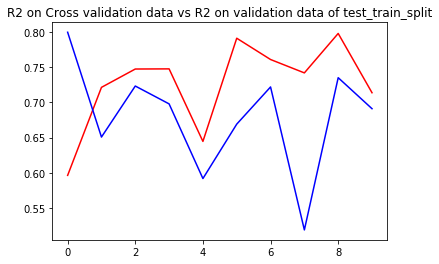

In [35]:
plt.title("R2 on Cross validation data vs R2 on validation data of test_train_split")
plt.plot(rf_reg_cv_scores, 'r')
plt.plot(rf_val_scores, 'b')

## 3. g. GridSearchCV to tune hyperparameter set on Random Forest

We have used GridSearchCV to tune the hyperparameter set of our model. This way we can get the best parameter set for our model to achieve a high R2 score. GridSearchCV performs cross validation using a combination of the parameters given as input and outputs the best parameter set for a given model. The R2 score of the model after performing GridSearchCV increased by just 2% after running several times with different variations in the hyperparameter set. The results are shown below:

In [39]:
print(f"Start time: {datetime.now()}")
rf_parameters = {'max_leaf_nodes':[None,2,5],'max_depth':[5,10,20,50,100],'min_samples_split':[2,4,5,8]}
rf_grid_search = GridSearchCV(RandomForestRegressor(),rf_parameters, cv=8)
rf_grid_search_result = rf_grid_search.fit(data,labels_raw)
print(f"Best parameters for RandomForestRegressor: {rf_grid_search_result.best_params_}")
print(f"End time: {datetime.now()}")

Start time: 2019-07-02 22:43:07.018896
Best parameters for RandomForestRegressor: {'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_split': 5}
End time: 2019-07-02 22:49:28.811367


In [40]:
rf_reg_cv = RandomForestRegressor(max_depth=20, max_leaf_nodes= None, min_samples_split= 8)
rf_reg_cv_cv_scores = cross_val_score(rf_reg_cv, data, labels_raw, cv=8)
print(f"R2 score: {sum(rf_reg_cv_cv_scores)/len(rf_reg_cv_cv_scores)}")

R2 score: 0.7421731109143743


## References:

1. Relief : https://epistasislab.github.io/scikit-rebate/installing/ 
2. R2 metric: http://www.fairlynerdy.com/what-is-r-squared/
3. Column value extraction: https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe
4. Tuning a model: https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models
5. Obtain unique values from a string: https://stackoverflow.com/questions/40389820/how-to-print-unique-words-from-an-inputted-string
6. Plotting graphs: https://stackoverflow.com/questions/48157735/plot-multiple-bars-for-categorical-data
7. Drop duplicates: https://jamesrledoux.com/code/drop_duplicates
8. Apply to each row in pandas: https://www.geeksforgeeks.org/python-pandas-apply/
9. Obtain portions of numpy array: https://machinelearningmastery.com/index-slice-reshape-numpy-arrays-machine-learning-python/